# Applying Tabular Q-Learning to the IPD

**Reinforcement learning** is a fascinating and exciting domain within machine learning. While there are a range of different approaches -- with more being continually researched and published -- the aim of this Jupyter notebook is to demonstrate how **tabular Q-learning** can be applied to the iterated prisoner's dilemma game.

## An introduction to Q-learning

**Q-learning** is an off-policy, model-free form of reinforcement learning that was outlined by (now Professor) Chris Watkins in his 1989 Cambridge University PhD thesis. In short, Q-learning agents apply some **behavioural policy** to pick actions in particular states (in our case, the **epsilon-greedy strategy**) and then learns some **target policy** by adjusting its **action-value function** `Q(s, a)` based on the received reward.

When using the epsilon-greedy strategy to select an action at each timestep, the agent either selects an action uniformly at random from the action space (here, `COOPERATE` or `DEFECT`) with probability `epsilon` or otherwise greedily selects the action associated with the highest Q-value the remainder of the time.

<center>
    <img alt="Q-learning behaviour (with the epsilon-greedy strategy)" src="images/qlearning-behaviour.png" width=320>
</center>

After playing the move, the agent receives a reward, which is used to update the action-value function in the following way:

<center>
    <img alt="Q-learning update rule" src="images/qlearning-update-rule.png" width=500>
</center>

You can think of the action-value function `Q(s, a)` as estimating the long-term discounted reward from taking action `a` in state `s`. 

Here, we are describing 'tabular' Q-learning, since `Q(s, a)` can essentially be represented as a giant table; however, this makes tabular Q-learning infeasible to apply in circumstances where there are large or even continuous state and action spaces. Instead, another approach is to parameterise `Q(s, a)` using a deep neural network instead of a table: this is the central idea behind **deep Q-learning**.

The tabular Q-learning agent used in the remainder of this notebook has been defined in the `examples/qlearning.py` file. You may wish to read through how it has been implemented first before continuing with this notebook. 

## Importing packages

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from engine import IPDGame, play_ipd
from examples.qlearning import *
from examples.simple import *
from submission.ipd import IPDPlayer

## Creating a training environment

With the iterated prisoner's dilemma being a two-player game, there are a range of different strategies you could employ to train your reinforcement learning agents, ranging from gameplay against a select group of rule-based agents to the idea of self-play. To get started, we will look at building an environment for training against a single rule-based agent, which you will later be able to adapt to implement your own ideas!

In [2]:
class SimpleIPDEnvironment:
    def __init__(self, agent: IPDPlayer, opponent: IPDPlayer) -> None:
        self.agent = agent
        self.opponent = opponent

    def reset(self) -> None:
        """Resets the environment to its initial state."""

        self.game = IPDGame()
        self.i = 0

    def step(self) -> None:
        """Steps the environment."""

        # Sample actions from the policy space
        move1 = self.agent.play_move(self.opponent)
        move2 = self.opponent.play_move(self.agent)

        # Perform the actions
        reward1, reward2 = self.game.play_move(move1, move2)

        # Pass on the reward signal to the players
        self.agent.update(move1, reward1)
        self.opponent.update(move2, reward2)

        self.i += 1

        # Return (state, reward, done)
        return (
            (self.game.moves1, self.game.moves2),
            reward1,
            self.i >= self.game.total_moves,
        )

## Training the agent

We start by defining a number of constants, which we can tune to affect the training process.

In [3]:
LEARNING_RATE = 0.1
DISCOUNT_FACTOR = 0.99
EPSILON = 0.2
EPISODES = 10

The next stage is to have our agent play a number of games (defined by `EPISODES`) against an opponent of our choice and (hopefully) learn a better policy!

In [4]:
agent = TabularQLearningAgent(epsilon=EPSILON)
opponent = TitForTat()

env = SimpleIPDEnvironment(agent, opponent)
rewards = []

for _ in range(EPISODES):
    env.reset()
    state = None
    done = False

    # Perform an episode
    while not done:
        # Step the environment
        (moves1, moves2), reward, done = env.step()

        rewards.append(reward)

        # Construct the new state
        move1, move2 = to_index(moves1[-1]), to_index(moves2[-1])
        new_state = (move1, move2)

        # Apply the Q-learning update rule
        if state:
            agent._q_table[state][move1] += LEARNING_RATE * (
                reward
                + DISCOUNT_FACTOR * agent._q_table[new_state].max()
                - agent._q_table[state][move1]
            )

        # Update the state
        state = new_state

## Saving the resulting Q-table

Having trained our agent, we can now save its Q-table so that we can reload it later, such as in a submission to DOXA (if you choose to modify this cell to save it in your `submission/` directory and update the code to use it).

In [5]:
agent.save_q_table("q_table.npz")

## Visualising the results

In order to evaluate the performance of our agent, it can be useful to graph its rewards over the training process.

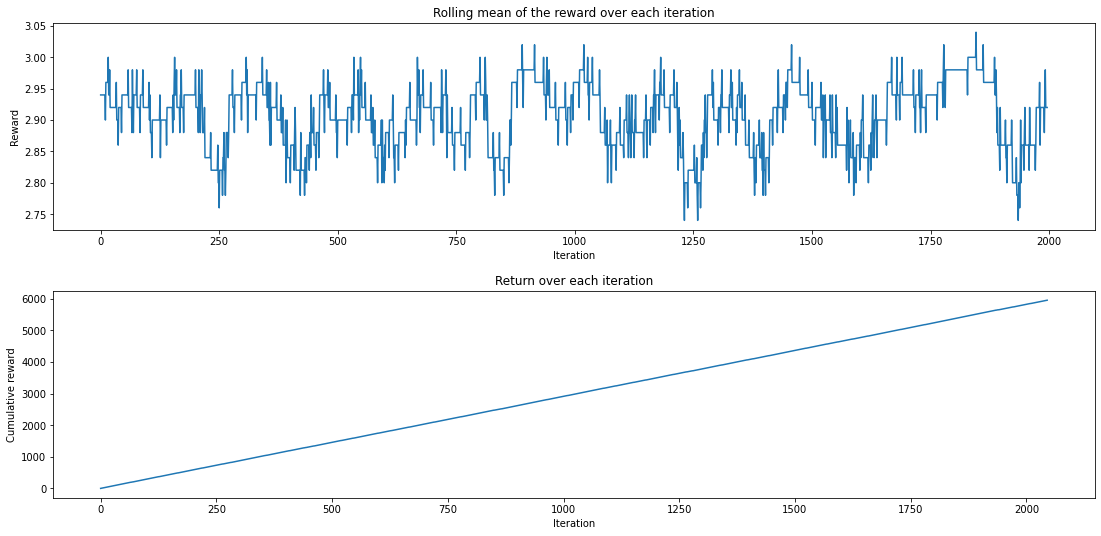

In [6]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(16, 8))
fig.tight_layout(pad=4)

ax1.set_title("Rolling mean of the reward over each iteration")
ax1.set_xlabel("Iteration")
ax1.set_ylabel("Reward")
ax1.plot(np.convolve(rewards, np.ones(50), 'valid') / 50)

ax2.set_title("Return over each iteration")
ax2.set_xlabel("Iteration")
ax2.set_ylabel("Cumulative reward")
ax2.plot(np.cumsum(rewards))

More directly, we can inspect the values of the Q-table itself, although this becomes impractical for larger Q-tables!

In [7]:
agent._q_table

array([[[236.43859432, 210.39283547],
        [229.46170191,  96.87555237]],

       [[217.01792215,  50.02526269],
        [125.05063372,   0.        ]]])

Finally, we can visualise the policy itself: which action our agent will take depending on the previous actions taken by it and its opponent.

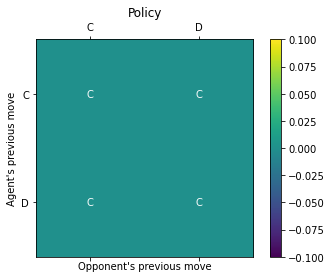

In [8]:
policy = agent._q_table.argmax(axis=2)

fig = plt.figure()
ax = fig.add_subplot(111)
m = ax.matshow(policy)
fig.colorbar(m)

ax.set_title("Policy")
ax.set_ylabel("Agent's previous move")
ax.set_xlabel("Opponent's previous move")
ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(["C", "D"])
ax.set_yticklabels(["C", "D"])

for (i, j), z in np.ndenumerate(policy):
    ax.text(j, i, "C" if z == 0 else "D", ha="center", va="center", color="white")
    

## The dangers of overfitting

Great! We have trained an agent that in general learns to cooperate when playing against `TitForTat`, as we might expect, but how well does this agent perform against other opponents?


In [9]:
# Load our trained agent (with epsilon=0 to use a totally greedy strategy in evaluation)
trained_agent = TabularQLearningAgent(epsilon=0, file="q_table.npz")

# Instantiate our opponent
all_d = AllD()

# Run a match
rewards = []
for i, (move1, move2), (reward1, reward2) in play_ipd(trained_agent, all_d):
    print(f"{i:<5} {move1} ({reward1}) | {move2} ({reward2})")
    rewards.append(reward1)

1     C (0) | D (5)
2     C (0) | D (5)
3     C (0) | D (5)
4     C (0) | D (5)
5     C (0) | D (5)
6     C (0) | D (5)
7     C (0) | D (5)
8     C (0) | D (5)
9     C (0) | D (5)
10    C (0) | D (5)
11    C (0) | D (5)
12    C (0) | D (5)
13    C (0) | D (5)
14    C (0) | D (5)
15    C (0) | D (5)
16    C (0) | D (5)
17    C (0) | D (5)
18    C (0) | D (5)
19    C (0) | D (5)
20    C (0) | D (5)
21    C (0) | D (5)
22    C (0) | D (5)
23    C (0) | D (5)
24    C (0) | D (5)
25    C (0) | D (5)
26    C (0) | D (5)
27    C (0) | D (5)
28    C (0) | D (5)
29    C (0) | D (5)
30    C (0) | D (5)
31    C (0) | D (5)
32    C (0) | D (5)
33    C (0) | D (5)
34    C (0) | D (5)
35    C (0) | D (5)
36    C (0) | D (5)
37    C (0) | D (5)
38    C (0) | D (5)
39    C (0) | D (5)
40    C (0) | D (5)
41    C (0) | D (5)
42    C (0) | D (5)
43    C (0) | D (5)
44    C (0) | D (5)
45    C (0) | D (5)
46    C (0) | D (5)
47    C (0) | D (5)
48    C (0) | D (5)
49    C (0) | D (5)
50    C (0) | D (5)


Oh dear, that doesn't look promising! Let's work out the cumulative reward (i.e. the return) of the game.

In [10]:
sum(rewards)

0

Well, that's disappointing! While our agent learns to do well against `TitForTat` by cooperating, it performs poorly against `AllD`, which is a significantly more exploitative opponent. This highlights the limits of using this strategy with the aim of training an agent that generalises to perform well against a range of opponents (such as the agents submitted to the IPD tournament on DOXA!), so where might you go from here?

## Next steps

There are a few different directions in which you could go. Here are just a few ideas:
- Train the model for a larger number of episodes
- Experiment with different learning rates and discount factors
    - Decrease the learning rate over time on a schedule
- Train agents against a pool of opponents, instead of just one
- Use a larger move history (perhaps taking into account the previous two or three moves instead of only the previous move), which could potentially allow the agent to discern between opponents' strategies
- Investigate the use of "experience replay"
- Switch to an approach based on deep Q-learning (DQN)
    - To do so, you may have to consider how you might want to represent the state.
    - What loss function might you want to use? (research the [Huber loss](https://pytorch.org/docs/stable/generated/torch.nn.HuberLoss.html))
- Try engineering some features from the game to use as input to a deep Q-network
- Try out double Q-learning (either tabular or DQN)
- Experiment with different deep Q-network architectures (e.g. in the paper [Playing Atari with Deep Reinforcement Learning](https://www.cs.toronto.edu/~vmnih/docs/dqn.pdf), Mnih et al. use a convolutional neural network, although that might be less appropriate in this setting)
- Research other reinforcement learning algorithms (e.g. [REINFORCE](https://people.cs.umass.edu/~barto/courses/cs687/williams92simple.pdf), [deep deterministic policy gradient](https://arxiv.org/pdf/1509.02971.pdf), [twin-delayed deep deterministic policy gradient](https://arxiv.org/pdf/1802.09477.pdf) (TD3), [proximal policy optimisation](https://arxiv.org/pdf/1707.06347.pdf), [soft actor-critic](https://arxiv.org/pdf/1801.01290.pdf), etc)

The DOXA execution environment includes both [tf-agents](https://www.tensorflow.org/agents) (based on [TensorFlow](https://www.tensorflow.org/)) and [PyTorch](https://pytorch.org/) that you can use to create your own agents.
